# Deep Classification of Dolphins, Belugas and Sharks
by: Babs Khalidson

## 1. Problem

Monitoring the number of sharks, belugas and dolphins can be very useful for institutions that are concerned about climate change and species preservation. However, manually sifting through months of data can be time-consuming and labour intensive. Moreover, classifying aquatic animals poses several challenges such as background noises, distortion of images, the presence of other water bodies in images and occlusion [(Rathi et al., 2018)](https://arxiv.org/abs/1805.10106).

## 2. Summary of Strategy

Aquatic life classification can be automated with the use of convolutional neural networks (CNNs), which are machine learning algorithms suited for image classification. herefore, I decided to create 3 image datasets from Google Images, where each contained around 250 images of Belugas, Dolphins and Sharks. After I cleaned the datasets by removing irrelevant images, I trained a CNN with the data and it was able to classify the fish with a **90.6% accuracy** on the test data set.

There is still room for improvement as this model could be improved with a larger data set, however, it still has some great use for saving time by automating manual classifications done by marine biologists in industry

## 3. Datasets

In [1]:
from fastai.vision import *
import pandas as pd

### 3.1 Creating the dataset

The data set was created using [Google Images](http://images.google.com). Highly specific search queries were used whilst also negating some queries to help reduce time spent on data cleaning. i.e "dolphins" -belugas -sharks -. 
Moreover, the maximum number of images that Google can show is 700, hence we were limited by that constraint. 

Once I had a page with reasonable results, I then proceeded to download the the images. This was done programmatically using some JavaScript code in my browser which saved the URLs of all the images I wanted in my data set. 

### 3.1.1 Steps for extracting the Image Urls

1) In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

2) You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### 3.1.2 Create directory and upload urls file into your server


Here I chose appropriate names for the labeled images. 

In [2]:
folder = 'dolphins'
file = 'dolphins/urls_dolphins.csv'


In [5]:
folder = 'greatwhite'
file = 'greatwhite/urls_great_white.csv'

In [6]:
folder = 'belugas'
file = 'belugas/urls_beluga.csv'

You will need to run this cell once per each category.

In [3]:
path = Path('/home/jupyter/tutorials/data/fish')

In [4]:
path.ls()

[PosixPath('/home/jupyter/tutorials/data/fish/.git'),
 PosixPath('/home/jupyter/tutorials/data/fish/belugas'),
 PosixPath('/home/jupyter/tutorials/data/fish/Belugas, Dolphins & Sharks.ipynb'),
 PosixPath('/home/jupyter/tutorials/data/fish/export.pkl'),
 PosixPath('/home/jupyter/tutorials/data/fish/dolphins'),
 PosixPath('/home/jupyter/tutorials/data/fish/greatwhite'),
 PosixPath('/home/jupyter/tutorials/data/fish/cleaned.csv'),
 PosixPath('/home/jupyter/tutorials/data/fish/models'),
 PosixPath('/home/jupyter/tutorials/data/fish/.gitattributes'),
 PosixPath('/home/jupyter/tutorials/data/fish/.ipynb_checkpoints')]

Finally, uploaded the urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](images/download_images/upload.png)

### 3.1.3 Download the images

Here I download the images from their respective URLs. fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

This will need to be run once per category.

In [9]:
classes = ['dolphins','greatwhite','belugas']

In [26]:
download_images(path/file, dest, max_pics=500, max_workers=0)

In [9]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [10]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

dolphins


sharks
belugas


### 3.1.4 View data

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [6]:
data.classes

['belugas', 'dolphins', 'greatwhite']

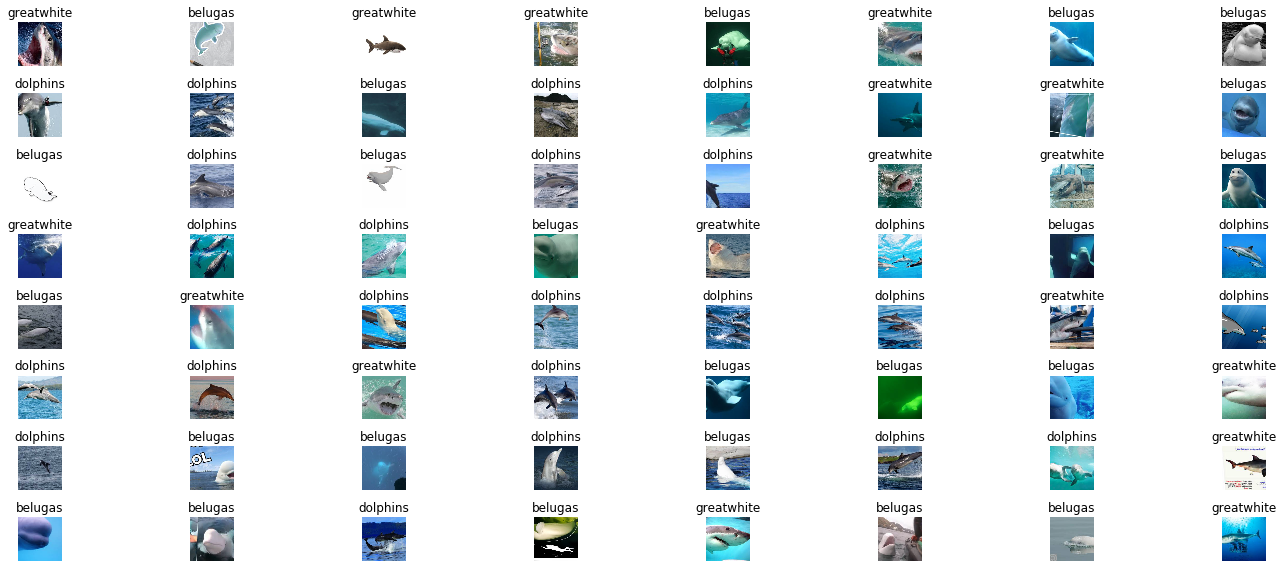

In [7]:
data.show_batch(rows=10, figsize=(20,8))

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['belugas', 'dolphins', 'greatwhite'], 3, 645, 161)

## 4. Training

In [9]:
learn = cnn_learner(data, models.resnet101, metrics=error_rate)

In [10]:
learn.fit_one_cycle(4)

In [11]:
learn.save('stage-1')

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


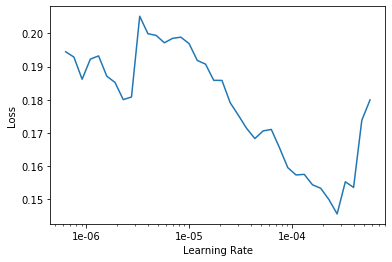

In [14]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

In [16]:
learn.save('stage-2')

## 5. Interpretation

In [17]:
learn.load('stage-2');

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

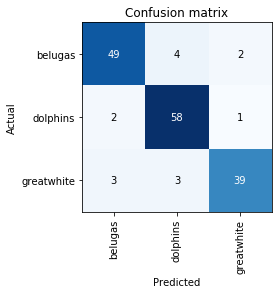

In [20]:
interp.plot_confusion_matrix()

## 6. Cleaning Up The Dataset

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [65]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [67]:
#If you already cleaned your data using indexes from `from_toplosses`,
 #run this cell instead of the one before to proceed with removing duplicates.
#Otherwise all the results of the previous step would be overwritten by
 #the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

Then we create a new learner to use our new databunch with all the images.

In [68]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [69]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [70]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [71]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [72]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## 7. Putting the model in production

First thing first, let's export the content of our `Learner` object for production:

In [73]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [75]:
defaults.device = torch.device('cpu')

Below I get a random image of a shark off the internet that the model has not seen to test its performance

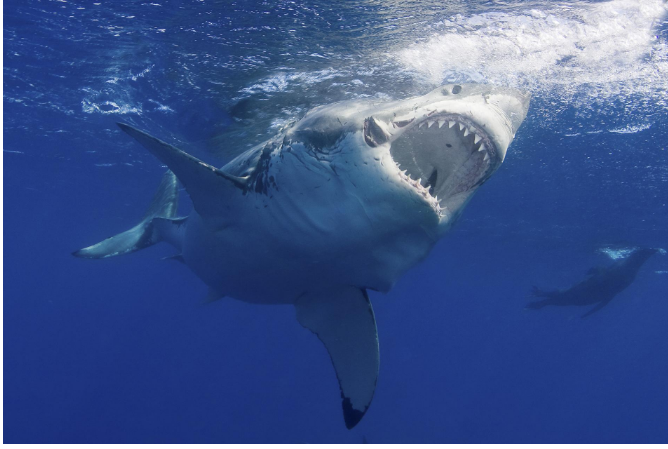

In [77]:
img = open_image(path/'greatwhite'/'greatwhitetest.png')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [78]:
learn = load_learner(path)

In [79]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category greatwhite

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## 8. Conclusion

This model can be a useful tool in industry that can help preserve Dolphins, Belugas and Sharks. Future work would involve using larger datasets and potentially building applications that would enable the CNN models to make predictions at a larger scale.